### Rappel Google Colab

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator. 
Installer ensuite deeplib avec la commande suivante:

In [1]:
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

  Cloning https://github.com/ulaval-damas/glo4030-labs.git to /tmp/pip-req-build-pqrofz_i


# Laboratoire 5: CNN

Dans ce laboratoire, nous allons implémenter avec l'aide de PyTorch divers réseaux à convolutions. La [documentation de PyTorch](https://pytorch.org/docs/stable/index.html) va donc vous être d'un grand secours. Entre autres, la documentation de [`torch`](https://pytorch.org/docs/stable/torch.html), [`torch.nn`](https://pytorch.org/docs/stable/nn.html) (que nous avons importé sous le nom de `nn`) ainsi que [`torch.nn.functional`](https://pytorch.org/docs/stable/nn.functional.html) (que nous avons importé sous le nom de `F`). En particulier, voici une liste de classes ou de fonctions dont vous êtes susceptible d'utiliser au cours de ce laboratoire.
- [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)
- [`nn.BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d)
- [`F.max_pool2d`](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.max_pool2d) ou [`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)
- [`F.relu`](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu) ou [`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)
- [`torch.flatten`](https://pytorch.org/docs/stable/generated/torch.flatten.html#torch.flatten) ou [`nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten)
- [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)
- [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential)
- [`nn.ModuleList`](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html#torch.nn.ModuleList)

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from deeplib.training import train, test
import torch.optim as optim
import torch
import numpy as np
from deeplib.datasets import load_cifar10, load_mnist
from deeplib.visualization import view_filters
import torch.nn.functional as F
import torch.nn as nn
from random import randrange

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

cifar_train, cifar_test = load_cifar10()
mnist_train, mnist_test = load_mnist()

Files already downloaded and verified
Files already downloaded and verified


## Filtres de convolution

Lors de l'entraînement, le réseau apprend les bons paramètres à utiliser. Par contre, autrefois, il fallait utiliser des filtres faits à la main comme [les filtres de Gabor](https://en.wikipedia.org/wiki/Gabor_filter).

#### Exercice

- Le réseau suivant contient une seule couche à convolution. Créez manuellement quelques filtres que vous utiliserez pour faire de la classification sur CIFAR10. Par la suite, figez les poids de la couche de convolution et entraînez le réseau. Tentez d'obtenir les meilleurs résultats possibles.

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.fc = nn.Linear(6 * 14 * 14, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = x.flatten(1)
        x = self.fc(x)
        return x

Modifier les paramètres des filtres. Essayez de faire des filtres permettant d'extraire des caractéristiques de bas niveau (ligne, coin, etc...). Vous pouvez consulter [ceci](http://lodev.org/cgtutor/filtering.html) pour avoir des idées.

In [4]:
filters = []
filters.append([[[0, 0, 0],
                 [0, 1, 0],
                 [0, 0, 0]]]) # Ce filtre retourne l'image original

"""
filters.append([[[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]]])

filters.append([[[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]]])

filters.append([[[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]]])

filters.append([[[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]]])

filters.append([[[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]]])
"""

# Arete verticales
filters.append([[[-1, 0, 1],
                 [-1, 0, 1],
                 [-1, 0, 1]]])

# Aretes horizontales
filters.append([[[-1, -1, -1],
                 [0, 0, 0],
                 [1, 1, 1]]])

# Motion blur (gaussien)
filters.append([[[1, 2, 1],
                 [2, 4, 2],
                 [1, 2, 1]]])

# Arete toute directions
filters.append([[[-1, -1, -1],
                 [-1, 8, -1],
                 [-1, -1, -1]]])

# Emboss (shadow effect of image)
filters.append([[[-1, -1, 0],
                 [-1, 0, 1],
                 [0, 1, 1]]])


In [5]:
# On crée le réseau, remplace les paramètres par les filtres précédents et fige les poids.

net = Net()
filters = np.asarray(filters, dtype=np.float32)
net.conv1.weight.data = torch.from_numpy(filters)
for param in net.conv1.parameters():
    param.requires_grad = False # Ceci fige chacune des couches
net = net.cuda()

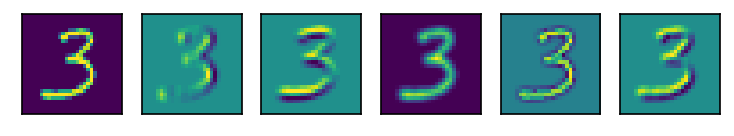

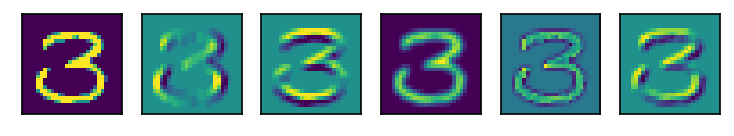

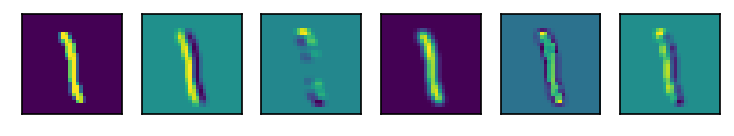

In [6]:
# Vous pouvez utiliser cette cellule pour visualiser l'effet de vos filtres sur des images du dataset.
for i in range(3):
    image, label = mnist_train[randrange(0, len(mnist_train))]
    view_filters(net, image)

In [7]:
lr = 0.001
n_epoch = 5
batch_size = 32

Epoch: 1/5 Step: 1500/1500 100.00% |████████████████████|9.73s loss: 0.272333 acc: 91.872917 val_loss: 0.181378 val_acc: 94.641667
Epoch: 2/5 Step: 1500/1500 100.00% |████████████████████|9.87s loss: 0.156442 acc: 95.256250 val_loss: 0.168487 val_acc: 94.975000
Epoch: 3/5 Step: 1500/1500 100.00% |████████████████████|10.04s loss: 0.128526 acc: 96.127083 val_loss: 0.142501 val_acc: 95.583333
Epoch: 4/5 Step: 1500/1500 100.00% |████████████████████|9.99s loss: 0.114003 acc: 96.600000 val_loss: 0.130124 val_acc: 96.175000
Epoch: 5/5 Step: 1500/1500 100.00% |████████████████████|9.80s loss: 0.104086 acc: 96.829167 val_loss: 0.123267 val_acc: 96.400000


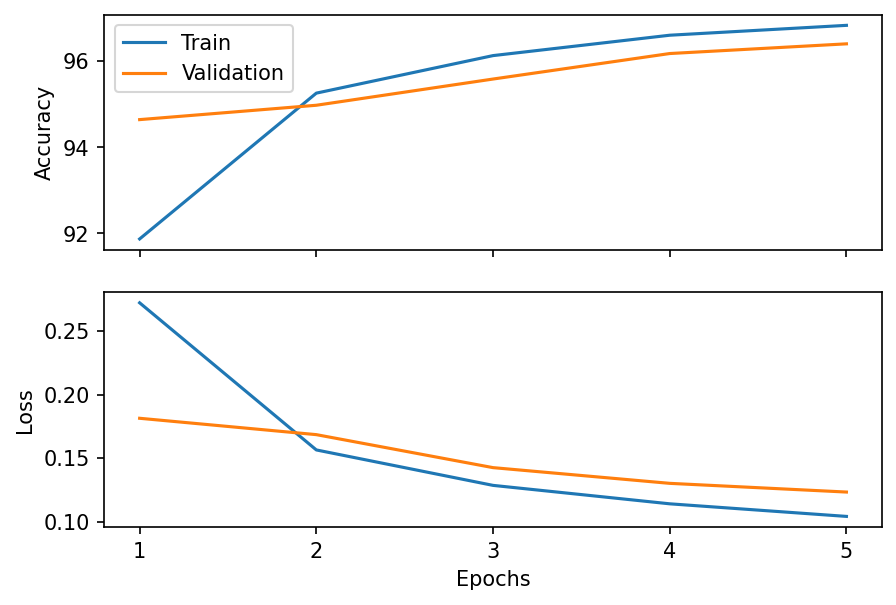

Précision en test: 96.32


In [8]:
optimizer = optim.Adam(net.fc.parameters(), lr=lr) # On optimise uniquement la couche pleinement connectée.
history = train(net, optimizer, mnist_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(net, mnist_test, batch_size)))

Entraînons maintenant le même réseau mais cette fois-ci, laissez l'optimiseur Adam faire son travail d'optimiser les couches à convolutions. Nous pourrons en même temps comparer si nos filtres faits à la main compétitionne avec les filtres entraînés. Remarquez cependant qu'ici, nous entraînons seulement avec 6 filtres et 1 seule couche alors qu'il est possible d'entraîner un réseau avec des milliers de filtres et plusieurs dizaines de couches.

Epoch: 1/5 Step: 1500/1500 100.00% |████████████████████|10.85s loss: 0.389304 acc: 89.395833 val_loss: 0.225179 val_acc: 93.425000
Epoch: 2/5 Step: 1500/1500 100.00% |████████████████████|10.90s loss: 0.180641 acc: 94.839583 val_loss: 0.149191 val_acc: 95.700000
Epoch: 3/5 Step: 1500/1500 100.00% |████████████████████|11.00s loss: 0.121499 acc: 96.543750 val_loss: 0.109591 val_acc: 96.725000
Epoch: 4/5 Step: 1500/1500 100.00% |████████████████████|11.01s loss: 0.092955 acc: 97.350000 val_loss: 0.094327 val_acc: 97.083333
Epoch: 5/5 Step: 1500/1500 100.00% |████████████████████|11.15s loss: 0.077944 acc: 97.766667 val_loss: 0.088044 val_acc: 97.383333


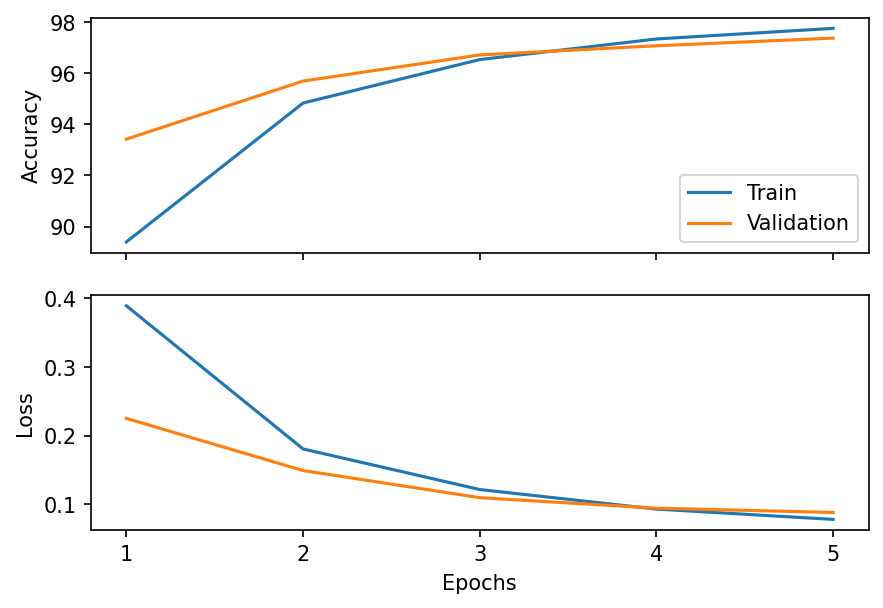

Précision en test: 97.62


In [9]:
net = Net()
net.cuda()

# On optimise autant la couche à convolution que la couche de classification.
optimizer = optim.Adam(net.parameters(), lr=lr)

history = train(net, optimizer, mnist_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(net, mnist_test, batch_size)))

Visualisons les filtres qui ont été appris par le réseau.

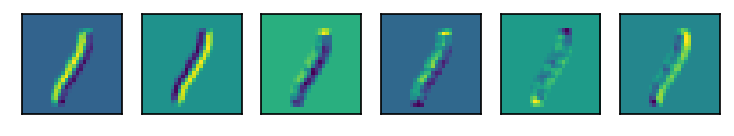

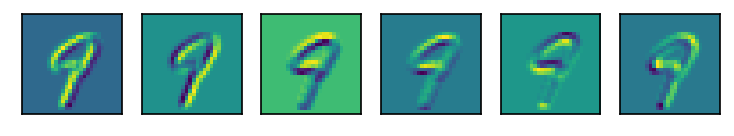

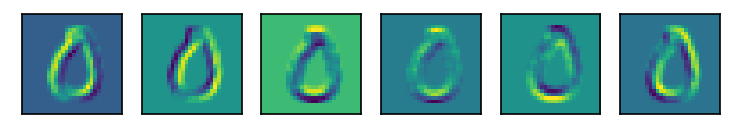

In [10]:
for i in range(3):
    image, label = mnist_train[randrange(0, len(mnist_train))]
    view_filters(net, image)

## Utilisation des filtres à convolutions

Comme on peut le constater dans l'interface de la classe [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) de PyTorch, les couches à convolutions ont des hyperparamètres ayant tous divers effets. Dans cette section, nous explorerons les plus importants.

Voici donc l'interface simplifiée de la classe:

`nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)`

Lorsqu'on utilise la classe, elle s'attend à recevoir en entrée un tenseur de taille `(taille de la batch, canaux, hauteur, largeur)`. Par exemple dans le cas de CIFAR10, on aurait en tenseur de taille `(taille de la batch, 3, 32, 32)`. Créons-nous un tenseur de taille similaire avec une taille de batch de 8 afin de tester la classe `nn.Conv2d` de PyTorch.

In [11]:
image_batch = torch.randn(8, 3, 32, 32)

Notez que le premier paramètre `in_channels` de `nn.Conv2d` doit correspondre au nombre de canaux (*channels*) du tenseur donné en entrée de la couche. Par exemple, la couche à convolution de 100 filtres 3x3 que l'on crée dans **le code suivant va nous donner une erreur** étant donné qu'on spécifie 2 canaux au lieu de 3.

In [12]:
conv = nn.Conv2d(2, 100, 3)
conv(image_batch)

RuntimeError: Given groups=1, weight of size [100, 2, 3, 3], expected input[8, 3, 32, 32] to have 2 channels, but got 3 channels instead

Créons maintenant une couche à convolution de 100 filtres 3x3 avec le bon nombre de canaux en entrée et regardons la shape du tenseur résultant.

In [13]:
conv = nn.Conv2d(3, 100, 3)
conv(image_batch).shape

torch.Size([8, 100, 30, 30])

On remarque que la taille du tenseur de sortie a 100 canaux étant donné qu'on a demandé 100 filtres à convolution. On remarque aussi que la hauteur et la largeur ont diminué de 2 dû à la convolution. Pour pallier à ceci, ajoutons un padding de 1.

In [14]:
conv = nn.Conv2d(3, 100, 3, padding=1)
conv(image_batch).shape

torch.Size([8, 100, 32, 32])

#### Exercice

- Quand vient le temps d'empiler les couches à convolution, il faut tenir compte du nombre de canaux en sortie de la couche précédente pour la couche suivante. Corrigez le code ci-dessous pour que l'appel des couches à convolution s'effectue sans erreur.

In [15]:
"""
# TODO Corrigez le code suivant
conv1 = nn.Conv2d(3, 100, 3, padding=1)
conv2 = nn.Conv2d(3, 100, 3, padding=1)
conv2(conv1(image_batch)).shape
"""

conv1 = nn.Conv2d(3, 100, 3, padding=1)
conv2 = nn.Conv2d(100, 100, 3, padding=1)
conv2(conv1(image_batch)).shape

torch.Size([8, 100, 32, 32])

#### Exercice

- Testons maintenant avec des filtres de tailles différentes. On remarquera que la hauteur et la largeur ont changé avec des filtres plus gros. Ajustez le padding pour que la hauteur et la largeur restent les mêmes, c'est-à-dire 32x32.

In [16]:
"""
conv = nn.Conv2d(3, 100, 5, padding=1)
print("Filtre 5x5:", conv(image_batch).shape)

conv = nn.Conv2d(3, 100, 7, padding=1)
print("Filtre 7x7:", conv(image_batch).shape)
"""

conv = nn.Conv2d(3, 100, 5, padding=2)
print("Filtre 5x5:", conv(image_batch).shape)

conv = nn.Conv2d(3, 100, 7, padding=3)
print("Filtre 7x7:", conv(image_batch).shape)

Filtre 5x5: torch.Size([8, 100, 32, 32])
Filtre 7x7: torch.Size([8, 100, 32, 32])


Mettons maintenant un *stride* de 2. Ceci va faire en sorte que les filtres à convolutions auront des déplacements de taille 2 au lieu de 1.

In [17]:
conv = nn.Conv2d(3, 100, 3, padding=1, stride=2)
conv(image_batch).shape

torch.Size([8, 100, 16, 16])

On remarque que la hauteur et la largeur du tenseur résultant ont été divisées par 2.

## Architecture de base

#### Exercice

- Implémentez une architecture de base de réseau de neurones à convolution pour CIFAR10 ayant les caractéristiques suivantes.

    1. 3 couches à convolution (voir [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)).
    2. Toutes les couches ont 100 filtres de taille 3x3 et 1 de padding.
    3. Batch normalization après chaque couche (voir [`nn.BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d)).
    4. Utiliser la ReLU comme fonction d'activation (Voir [`F.relu`](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu) ou [`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)).
    5. Maxpooling avec un noyau de taille 2 après les 2 premières couches. (Voir [`F.max_pool2d`](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.max_pool2d) ou [`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)).
    6. 1 seule couche linéaire pour la classification (aucune activation nécessaire) (Voir [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)).

Ne pas oublier d'utiliser [`torch.flatten`](https://pytorch.org/docs/stable/generated/torch.flatten.html#torch.flatten) ou [`nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten) avant la couche de classification sinon vous allez obtenir des erreurs de *shape*.

Essentiellement, chaque couche devrait consister en `Conv2d -> BatchNorm2d -> ReLU` suivi de `MaxPool2d` pour les deux premières couches. Notez que le maxpooling et la ReLU pourraient être échangés étant donné que tous les deux sont des opérations de maximum. Pour vous faciliter les prochains exercices, on vous demande de suivre l'ordre donné ici.

Notez que la taille des images de CIFAR10 est de 3x32x32 (images en couleur). Il faut donc tenir en compte de cela lors de l'instanciation de la première couche à convolutions.

In [18]:
"""
class ConvNet(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        pass

    def forward(self, x):
        pass
"""

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 100, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(100)
        
        self.conv2 = nn.Conv2d(100, 100, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(100)
        
        self.conv3 = nn.Conv2d(100, 100, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(100)
        
        self.fc = nn.Linear(100 * 8 * 8, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.relu(self.bn2(self.conv3(x)))
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [19]:
lr = 0.001
n_epoch = 10
batch_size = 32

Epoch:  1/10 Step: 1250/1250 100.00% |████████████████████|14.06s loss: 1.251773 acc: 56.467500 val_loss: 1.244048 val_acc: 59.350000
Epoch:  2/10 Step: 1250/1250 100.00% |████████████████████|13.87s loss: 0.811752 acc: 71.825000 val_loss: 1.303286 val_acc: 53.560000
Epoch:  3/10 Step: 1250/1250 100.00% |████████████████████|14.41s loss: 0.654377 acc: 77.435000 val_loss: 1.212830 val_acc: 58.250000
Epoch:  4/10 Step: 1250/1250 100.00% |████████████████████|13.98s loss: 0.542035 acc: 81.172500 val_loss: 1.154413 val_acc: 59.710000
Epoch:  5/10 Step: 1250/1250 100.00% |████████████████████|14.25s loss: 0.444124 acc: 84.810000 val_loss: 1.120426 val_acc: 61.380000
Epoch:  6/10 Step: 1250/1250 100.00% |████████████████████|14.36s loss: 0.359585 acc: 87.515000 val_loss: 1.294525 val_acc: 55.560000
Epoch:  7/10 Step: 1250/1250 100.00% |████████████████████|13.44s loss: 0.289776 acc: 90.152500 val_loss: 1.102831 val_acc: 61.880000
Epoch:  8/10 Step: 1250/1250 100.00% |████████████████████|13.

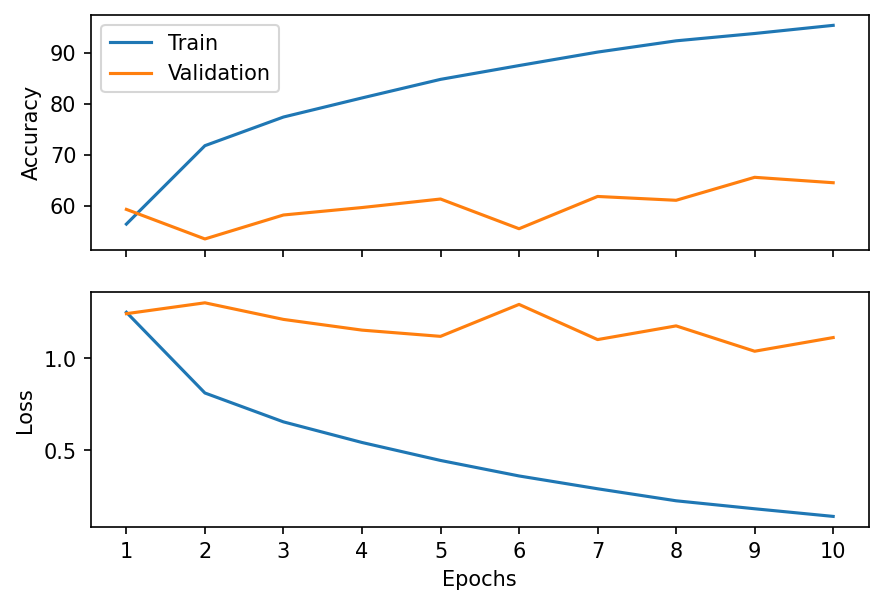

Précision en test: 64.02


In [20]:
model = ConvNet()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

## Architecture profonde

#### Exercice

- Ajoutez 2 couches de convolution de 100 filtres dans le réseau précédent (n'oubliez pas la batch normalization et le padding). Mettez du maxpooling après la couche 1 et 3. Comparez les résultats.

In [21]:
"""
class ConvNet(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        pass

    def forward(self, x):
        pass
"""

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 100, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(100)
        
        self.conv2 = nn.Conv2d(100, 100, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(100)
        
        self.conv3 = nn.Conv2d(100, 100, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(100)
        
        self.conv4 = nn.Conv2d(100, 100, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(100)
        
        self.conv5 = nn.Conv2d(100, 100, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(100)
        
        self.fc = nn.Linear(100 * 8 * 8, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = x.flatten(1)
        x = self.fc(x)
        return x

Epoch:  1/10 Step: 1250/1250 100.00% |████████████████████|15.66s loss: 1.293686 acc: 54.715000 val_loss: 1.248241 val_acc: 57.850000
Epoch:  2/10 Step: 1250/1250 100.00% |████████████████████|15.14s loss: 0.812554 acc: 71.682500 val_loss: 1.387517 val_acc: 56.320000
Epoch:  3/10 Step: 1250/1250 100.00% |████████████████████|16.95s loss: 0.643426 acc: 77.637500 val_loss: 0.843463 val_acc: 71.810000
Epoch:  4/10 Step: 1250/1250 100.00% |████████████████████|17.07s loss: 0.516137 acc: 81.910000 val_loss: 0.915476 val_acc: 70.640000
Epoch:  5/10 Step: 1250/1250 100.00% |████████████████████|17.21s loss: 0.415085 acc: 85.610000 val_loss: 0.774401 val_acc: 74.640000
Epoch:  6/10 Step: 1250/1250 100.00% |████████████████████|16.69s loss: 0.322957 acc: 88.775000 val_loss: 0.685345 val_acc: 77.790000
Epoch:  7/10 Step: 1250/1250 100.00% |████████████████████|16.81s loss: 0.246084 acc: 91.332500 val_loss: 0.698479 val_acc: 78.330000
Epoch:  8/10 Step: 1250/1250 100.00% |████████████████████|16.

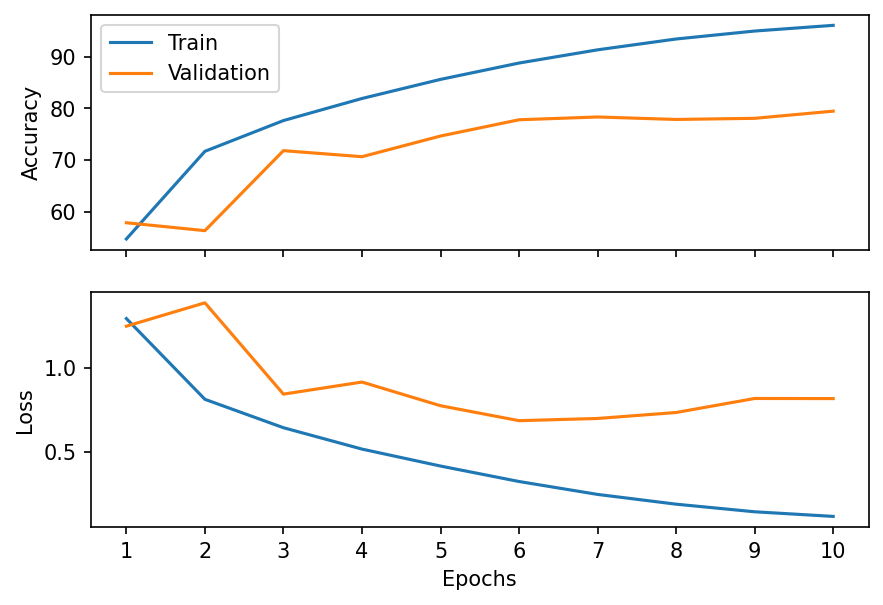

Précision en test: 79.13


In [22]:
model = ConvNet()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

#### Question
- Que remarquez-vous par rapport au performance du réseau précédent? 
    
    **En rajoutant quelques couches, dans ce cas-ci, les performances sont augmentés.**

#### Exercice

- Codez le réseau ci-dessous qui prend en paramètre le nombre de couches désiré. Vous allez devoir utiliser la classe [`nn.ModuleList`](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html#torch.nn.ModuleList) pour pouvoir avoir un nombre variable de couches. Encore une fois, chaque couche va consister en 100 filtres à convolution 3x3 avec padding de 1 suivi d'une batch normalization et d'une ReLU. Mettez du maxpooling après les couches 3 et 5. Vous pouvez supposer que le nombres de couche demandé est plus de 5. Entrainez ensuite le réseau avec 51 couches.

    L'entraînement risque de prendre un certain temps. Vous avez certainement le temps d'aller prendre un bon café.

In [23]:
"""
class ConvNet(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        assert num_layers > 5
        pass

    def forward(self, x):
        pass
"""

class ConvNet(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        assert num_layers > 5
        self.num_layers = num_layers
        
        self.conv1 = nn.Conv2d(3, 100, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(100)
        
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        for _ in range(num_layers - 1):
            self.convs.append(nn.Conv2d(100, 100, 3, padding=1))
            self.bns.append(nn.BatchNorm2d(100))
        
        self.fc = nn.Linear(100 * 8 * 8, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Cette boucle parcourt les couches 2 à num_layers.
        for layer_number, conv, bn in zip(range(2, self.num_layers + 1), self.convs, self.bns):
            x = F.relu(bn(conv(x)))
            if layer_number in [3, 5]:
                x = F.max_pool2d(x, 2)
        
        x = x.flatten(1)
        x = self.fc(x)
        return x

Epoch:  1/10 Step: 1250/1250 100.00% |████████████████████|75.33s loss: 2.285147 acc: 12.100000 val_loss: 2.296614 val_acc: 10.700000
Epoch:  2/10 Step: 1250/1250 100.00% |████████████████████|73.89s loss: 2.151984 acc: 15.522500 val_loss: 1.987416 val_acc: 19.950000
Epoch:  3/10 Step: 1250/1250 100.00% |████████████████████|74.88s loss: 1.892004 acc: 23.230000 val_loss: 1.874513 val_acc: 25.220000
Epoch:  4/10 Step: 1250/1250 100.00% |████████████████████|73.82s loss: 1.786655 acc: 29.615000 val_loss: 1.794328 val_acc: 31.860000
Epoch:  5/10 Step: 1250/1250 100.00% |████████████████████|77.11s loss: 1.757842 acc: 31.325000 val_loss: 1.727923 val_acc: 30.770000
Epoch:  6/10 Step: 1250/1250 100.00% |████████████████████|74.71s loss: 1.806812 acc: 28.135000 val_loss: 1.664059 val_acc: 34.180000
Epoch:  7/10 Step: 1250/1250 100.00% |████████████████████|75.33s loss: 2.014101 acc: 22.520000 val_loss: 2.079660 val_acc: 20.060000
Epoch:  8/10 Step: 1250/1250 100.00% |████████████████████|74.

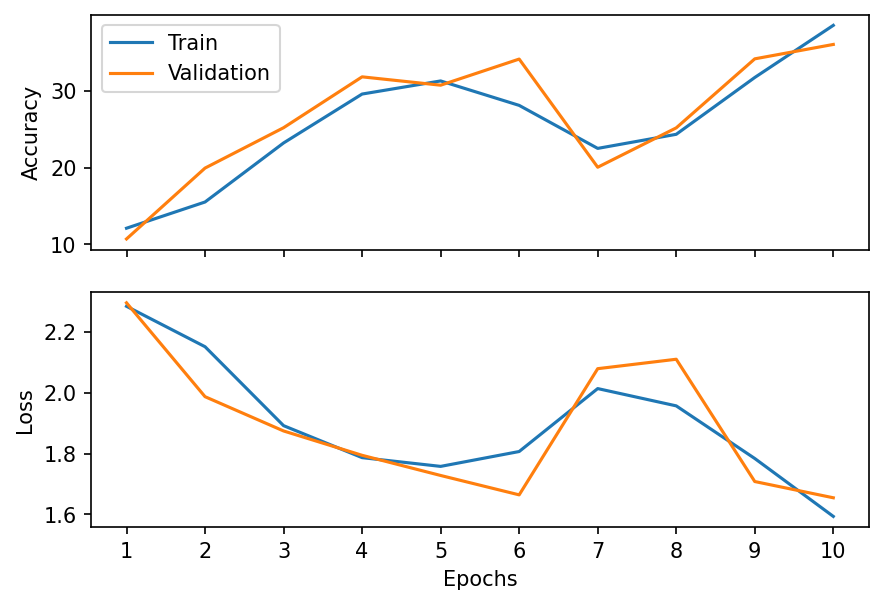

Précision en test: 36.23


In [24]:
model = ConvNet(51)
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

#### Question

- Que remarquez-vous par rapport au performance du réseau précédent? 
    
    **En rajoutant beaucoup de couches, dans ce cas-ci, les performances sont diminués.**

### Un petit défi (exercice facultatif)

PyTorch fournit l'interface de programmation [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) permettant de programmer et de visualiser plus facilement les réseaux programmables sous forme de couches. Au lieu d'hériter de la classe [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module), on instancie un objet `nn.Sequential` avec les couches désirés en paramètre. L'objet `nn.Sequential` se chargera d'appeler dans l'ordre fourni chaque couche avec en entrée la sortie de la couche précédente.

Prenons l'exemple ci-dessous qui contient seulement une couche à convolutions, quelques activations et une couche linéaire.

In [25]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 100, 3, padding=1)
        self.fc = nn.Linear(100 * 16 * 16, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = x.flatten(1)
        x = self.fc(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=25600, out_features=10, bias=True)
)


En utilisant l'interface `nn.Sequential`, On peut simplifier le code comme ci-dessous. On remarquera également qu'avec l'affichage d'un réseau utilisant `nn.Sequential`, les opérations exécutées par le réseau sont beaucoup clairs et explicites qu'avec `nn.Module`.

In [26]:
def create_sequential_network():
    return nn.Sequential(
        nn.Conv2d(3, 100, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(100 * 16 * 16, 10)
    )

net = create_sequential_network()
print(net)

Sequential(
  (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=25600, out_features=10, bias=True)
)


On vous soumet donc ici un défi. Le but est de réimplémenter le réseau que l'on vient de coder en utilisant l'interface `nn.Sequential`.

In [27]:
"""
def create_sequential_conv_net(num_layers):
    assert num_layers > 5
    layers = []

    # TODO Ajoutez les couches à la liste "layers" ici.

    return nn.Sequential(*layers)
"""

def create_sequential_conv_net(num_layers):
    assert num_layers > 5

    # Création de la première couche.
    layers = [
        nn.Conv2d(3, 100, 3, padding=1),
        nn.BatchNorm2d(100),
        nn.ReLU()
    ]

    # Cette boucle ajoute les couches 2 à num_layers.
    for layer_number in range(2, num_layers + 1):
        layers.append(nn.Conv2d(100, 100, 3, padding=1))
        layers.append(nn.BatchNorm2d(100))
        layers.append(nn.ReLU())
        if layer_number in [3, 5]: 
            layers.append(nn.MaxPool2d(2))

    layers.append(nn.Flatten())
    layers.append(nn.Linear(100 * 8 * 8, 10))

    return nn.Sequential(*layers)

Epoch:  1/10 Step: 1250/1250 100.00% |████████████████████|74.41s loss: 2.292753 acc: 11.707500 val_loss: 2.099531 val_acc: 17.940000
Epoch:  2/10 Step: 1250/1250 100.00% |████████████████████|74.71s loss: 2.009376 acc: 20.237500 val_loss: 1.951352 val_acc: 21.360000
Epoch:  3/10 Step: 1250/1250 100.00% |████████████████████|69.28s loss: 1.897974 acc: 23.617500 val_loss: 2.049387 val_acc: 20.880000
Epoch:  4/10 Step: 1250/1250 100.00% |████████████████████|68.92s loss: 1.768447 acc: 30.222500 val_loss: 1.685337 val_acc: 35.070000
Epoch:  5/10 Step: 1250/1250 100.00% |████████████████████|68.76s loss: 1.603359 acc: 37.732500 val_loss: 1.571938 val_acc: 40.990000
Epoch:  6/10 Step: 1250/1250 100.00% |████████████████████|69.09s loss: 1.445166 acc: 46.220000 val_loss: 1.417049 val_acc: 48.840000
Epoch:  7/10 Step: 1250/1250 100.00% |████████████████████|68.42s loss: 1.333796 acc: 51.690000 val_loss: 1.291888 val_acc: 52.370000
Epoch:  8/10 Step: 1250/1250 100.00% |████████████████████|69.

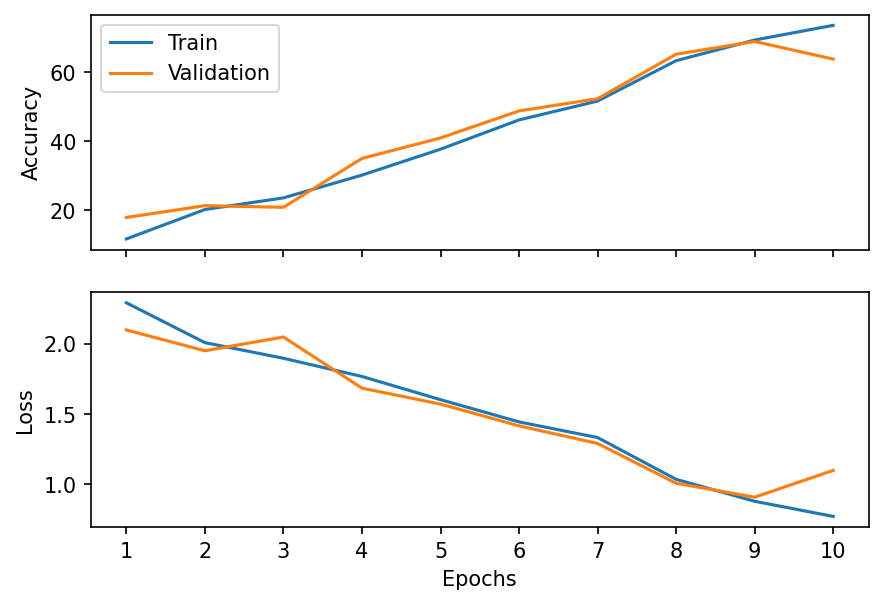

Précision en test: 63.30


In [28]:
model = create_sequential_conv_net(51)
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

## Connexion résiduelle

Comme vous avez pu le constater, ajouter de plus en plus de couches augmente aussi la difficulté avec laquelle le gradient peut se propager dans le réseau. Une des solutions suggérées est d'utiliser une connexion résiduelle permettant au gradient de _sauter_ des couches. Dans l'article présentant cette connexion, elle est définie comme suit:

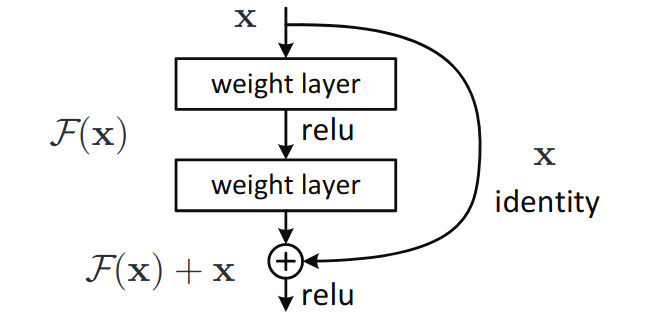

#### Exercice

- Implémentez cette connexion sous une forme de couche dans la classe `ResidualLayer` ci-dessous. Vous pouvez la tester avec le réseau `ShallowResnet` fourni ci-bas. Dans notre cas, chaque *weight layer* consiste en une couche à convolution à 100 filtres 3x3 avec padding de 1 suivi d'une batch normalization. Prenez pour acquis que le nombre de *canaux* en entrée de votre couche sera de 100.

In [29]:
"""
class ResidualLayer(nn.Module):
    def __init__(self):
        super().__init__()
        pass
    
    def forward(self, x):
        pass
"""

class ResidualLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(100, 100, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(100)

        self.conv2 = nn.Conv2d(100, 100, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(100)
    
    def forward(self, x):
        res = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = F.relu(x + res)
        return x

Testez votre implémentation de votre couche résiduelle avec le réseau peu profond ci-dessous.

In [30]:
class ShallowResnet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 100, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(100)
        
        self.res1 = ResidualLayer()
        self.res2 = ResidualLayer()
        self.res3 = ResidualLayer()

        self.fc1 = nn.Linear(100 * 8 * 8, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.res1(x)
        x = F.max_pool2d(x, 2)
        x = self.res2(x)
        x = F.max_pool2d(x, 2)
        x = self.res3(x)
        x = x.flatten(1)
        x = self.fc1(x)
        return x

Epoch:  1/10 Step: 1250/1250 100.00% |████████████████████|20.51s loss: 1.682178 acc: 48.440000 val_loss: 1.192382 val_acc: 60.590000
Epoch:  2/10 Step: 1250/1250 100.00% |████████████████████|20.97s loss: 1.007982 acc: 65.685000 val_loss: 0.982165 val_acc: 66.540000
Epoch:  3/10 Step: 1250/1250 100.00% |████████████████████|20.43s loss: 0.791292 acc: 72.917500 val_loss: 0.780691 val_acc: 73.450000
Epoch:  4/10 Step: 1250/1250 100.00% |████████████████████|20.43s loss: 0.643383 acc: 77.902500 val_loss: 1.021292 val_acc: 68.730000
Epoch:  5/10 Step: 1250/1250 100.00% |████████████████████|20.54s loss: 0.535321 acc: 81.247500 val_loss: 0.750667 val_acc: 75.190000
Epoch:  6/10 Step: 1250/1250 100.00% |████████████████████|20.38s loss: 0.435604 acc: 84.855000 val_loss: 0.695190 val_acc: 77.470000
Epoch:  7/10 Step: 1250/1250 100.00% |████████████████████|20.29s loss: 0.337140 acc: 88.227500 val_loss: 0.665332 val_acc: 78.340000
Epoch:  8/10 Step: 1250/1250 100.00% |████████████████████|20.

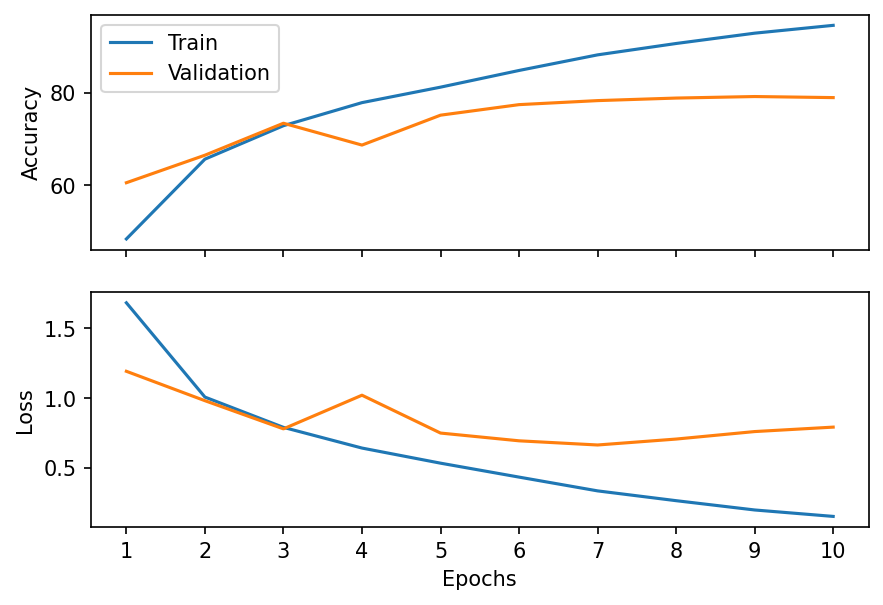

Précision en test: 79.21


In [31]:
model = ShallowResnet()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

#### Exercice

- Codez le réseau à connexion résiduelle ci-dessous qui prend en paramètre le nombre de couches résiduelles désiré. Encore une fois, vous allez devoir utiliser la classe [`nn.ModuleList`](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html#torch.nn.ModuleList) ou [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) pour pouvoir avoir un nombre variable de couches. Notez qu'ici `num_layers` représente le nombre de couches résiduelles et non le nombre de couches à convolution. Le réseau devrait consister d'une couche `Conv2d -> BatchNorm2d -> ReLU` suivi de `num_layers` couches résiduelles et terminer par la couche de classification. Faites un maxpool après les couches résiduelles 1 et 2. 

    Entrainez le réseau avec 25 couches résiduelles (donc au total 51 couches à convolution si compte la première couche non résiduelle).

In [32]:
"""
class Resnet(nn.Module):
    def __init__(self, num_layers):
        super(Resnet, self).__init__()
        pass

    def forward(self, x):
        pass
"""


class Resnet(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        assert num_layers > 2
        
        self.conv1 = nn.Conv2d(3, 100, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(100)
        
        self.layers = nn.ModuleList([
            ResidualLayer() for _ in range(num_layers)
        ])
            
        self.fc1 = nn.Linear(100 * 8 * 8, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))

        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i <= 1:
                x = F.max_pool2d(x, 2)

        x = x.flatten(1)
        x = self.fc1(x)
        return x

Epoch:  1/10 Step: 1250/1250 100.00% |████████████████████|71.03s loss: 1.967118 acc: 48.030000 val_loss: 1.368332 val_acc: 56.510000
Epoch:  2/10 Step: 1250/1250 100.00% |████████████████████|70.08s loss: 0.924306 acc: 68.455000 val_loss: 1.121250 val_acc: 67.670000
Epoch:  3/10 Step: 1250/1250 100.00% |████████████████████|71.13s loss: 0.723418 acc: 75.007500 val_loss: 0.766967 val_acc: 74.820000
Epoch:  4/10 Step: 1250/1250 100.00% |████████████████████|70.89s loss: 0.571818 acc: 80.197500 val_loss: 0.954334 val_acc: 74.460000
Epoch:  5/10 Step: 1250/1250 100.00% |████████████████████|71.16s loss: 0.464040 acc: 84.010000 val_loss: 0.712030 val_acc: 77.380000
Epoch:  6/10 Step: 1250/1250 100.00% |████████████████████|69.97s loss: 0.352550 acc: 87.707500 val_loss: 0.739661 val_acc: 77.050000
Epoch:  7/10 Step: 1250/1250 100.00% |████████████████████|68.87s loss: 0.259464 acc: 90.882500 val_loss: 0.771676 val_acc: 78.640000
Epoch:  8/10 Step: 1250/1250 100.00% |████████████████████|69.

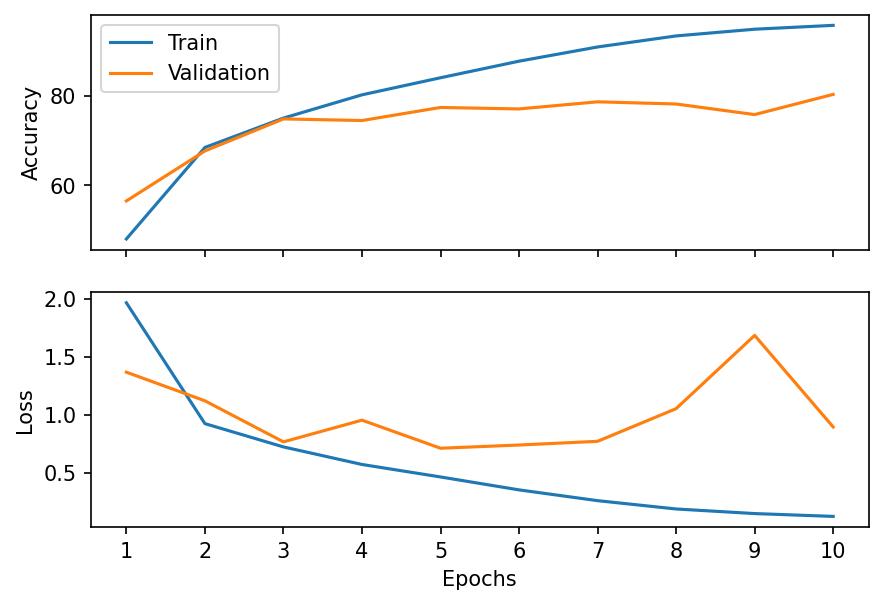

Précision en test: 79.89


In [33]:
model = Resnet(25)
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

#### Question

- Comparez les résultats et la vitesse avec laquelle le réseau a entraîné par rapport au réseau à convolution de 51 couches entrainé plus haut. 

    **On remarque que les connexions résiduelles ont aidés l'entraînement.**

#### Exercice facultatif

- Comme le défi lancé précédemment, tentez d'implémenter le réseau à connexion résiduelle en n'utilisant que l'interface `nn.Sequential`. Vous pouvez utiliser la couche `ResidualLayer` définie précédemment.

In [34]:
"""
def create_sequential_resnet(num_layers):
    assert num_layers > 2
    layers = []
    
    # TODO Ajoutez les couches à la liste "layers" ici.

    return nn.Sequential(*layers)
"""

def create_sequential_resnet(num_layers):
    assert num_layers > 2

    layers = [
        nn.Conv2d(3, 100, 3, padding=1),
        nn.BatchNorm2d(100),
        nn.ReLU()
    ]

    for i in range(num_layers):
        layers.append(ResidualLayer())
        if i <= 1:
            layers.append(nn.MaxPool2d(2))

    layers.append(nn.Flatten())
    layers.append(nn.Linear(100 * 8 * 8, 10))

    return nn.Sequential(*layers)

Epoch:  1/10 Step: 1250/1250 100.00% |████████████████████|72.45s loss: 2.069424 acc: 46.827500 val_loss: 1.340021 val_acc: 62.330000
Epoch:  2/10 Step: 1250/1250 100.00% |████████████████████|72.49s loss: 0.962370 acc: 67.392500 val_loss: 1.241245 val_acc: 68.960000
Epoch:  3/10 Step: 1250/1250 100.00% |████████████████████|72.78s loss: 0.730783 acc: 74.950000 val_loss: 0.885017 val_acc: 71.970000
Epoch:  4/10 Step: 1250/1250 100.00% |████████████████████|70.56s loss: 0.591217 acc: 79.507500 val_loss: 0.828102 val_acc: 74.910000
Epoch:  5/10 Step: 1250/1250 100.00% |████████████████████|72.49s loss: 0.474384 acc: 83.635000 val_loss: 0.871503 val_acc: 75.650000
Epoch:  6/10 Step: 1250/1250 100.00% |████████████████████|71.25s loss: 0.366191 acc: 87.302500 val_loss: 0.673409 val_acc: 78.770000
Epoch:  7/10 Step: 1250/1250 100.00% |████████████████████|67.53s loss: 0.275683 acc: 90.315000 val_loss: 0.771924 val_acc: 77.520000
Epoch:  8/10 Step: 1250/1250 100.00% |████████████████████|67.

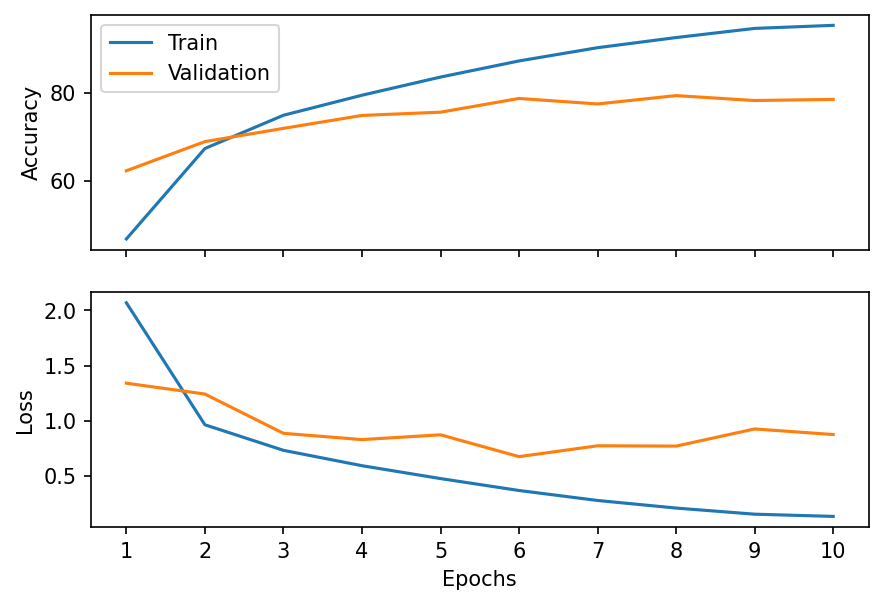

Précision en test: 78.74


In [35]:
model = create_sequential_resnet(25)
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))